In [ ]:
import os
import time
import numpy as np
import pandas as pd
from typing import Tuple
import random
from collections import defaultdict
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# 환경 코드 구현

In [ ]:
import numpy as np
from typing import Tuple

In [ ]:
class GridWorldEnvironment: # 환경 클래스 생성
    def __init__(self, start_point: Tuple, end_point: Tuple, gridworld_size:Tuple) :
        # 튜플로 좌표 넘겨 받기, 시작, 끝, 크기
        self.start_point=start_point
        if end_point != (-1,-1) :
            self.end_point= end_point
        else : # -1, -1 입력하면 알아서 맨 오른쪽 끝 좌표를 가리키게 하도록한다
            self.end_point=(gridworld_size[0]-1, gridworld_size[1]-1)

        self.height, self.width =gridworld_size
        # action dictionary
        self.action_space =['up', 'down', 'left', 'right'] # 행동 스페이스, 상하좌우
        self.num_actions = len(self.action_space)

        self.actions={}
        dy=[-1,1,0,0]
        dx=[0,0,-1,1]
        for i in range(len(dy)) :
            self.actions[self.action_space[i]] = (dy[i], dx[i])

        # 상태: 좌표, 에이전트가 움직인 좌표를 모두 담음
        self.traces=[]

        # total states
        self.total_states=[] # 모든 상태 좌표를 담음

        for i in range(self.height):
            for j in range(self.width):
                self.total_states.append((i,j))

        # 보상
        # 처음은 0으로 초기화
        self.reward = np.zeros((self.height, self.width)).tolist()
        self.reward[end_point[0]][end_point[1]] = 1

    # 그리기 함수
    def render(self) :
        # . 으로 초기화
        self.grid_world = np.full((self.height, self.width), fill_value=".").tolist()

        last_point = self.traces[-1] # 에이전트가 가장 마지막에 있었던 위치
        traces = list(set(self.traces)) # 중복된 값 삭제

        for trace in traces :
            self.grid_world[trace[0]][trace[1]] = 'x'

        self.grid_world[self.start_point[0]][self.start_point[1]]='S'
        self.grid_world[self.end_point[0]][self.end_point[1]]= 'G'
        self.grid_world[last_point[0]][last_point[1]] = 'A'

        # string 으로 출력
        for i in range(self.height) :
            grid=""
            for j in range(self.width) :
                grid += self.grid_world[i][j]+' '
            print(grid)

    # 3
    def check_boundary(self, state) :
        state = list(state) # 튜플은 수정할 수 없기 때문에 list
        for i in range(2) :
            if state[i] < 0 :
                state[i] = 0
            if i== 0 and state[i] >= self.height :
                state[i] = self.height-1
            if i==1 and state[i] >= self.width :
                state[i] = self.width-1

        return tuple(state) # 다시 튜플로 return

    # 2
    def state_after_action(self, state, action_idx:int) :
        action=self.action_space[action_idx] # up down ..
        rm, cm = self.actions[action]
        next_state = (state[0]+rm,state[1]+cm)
        return self.check_boundary(next_state)

    # 1
    def get_reward (self, state, action_idx) :
        next_state = self.state_after_action(state, action_idx)
        return self.reward[next_state[0]][next_state[1]]

# 다이나믹 프로그래밍

## 정책이터레이션

In [ ]:
class PolicyIteration:
    def __init__(self, env) :
        self.env=env
        self.action_space=env.action_space # 상하좌우
        self.num_action = env.num_actions

        self.value_table = np.zeros((env.height, env.width)).tolist()

        # 정책 테이블 : 3차원 테이블, 상하좌우 모두 0.25 로 초기화
        self.policy_table = np.full((env.height, env.width, self.num_action),
                                    fill_value=0.25).tolist()

        # GOAL 지점은 상하좌우로 이동할 필요가 없으므로 [] 로 초기화
        self.policy_table[env.end_point[0]][env.end_point[1]] = []

        self.gamma = 0.9 # 할인률은 0.9로 통일

    # 정책 평가
    def policy_evaluation(self) :
        for state in self.env.total_states:
            # 벨만 기대 방정식을 이용해 현재 정책에 대한 각 state의 가치를 구하기
            value = 0.0

            # 상태가 goal이라면 value 는 0 으로
            if state == self.env.end_point :
                self.value_table[state[0]][state[1]] = 0.0
            # goal이 아니라면
            else :
                state_policy = self.get_policy(state) # 상하좌우 확률 받기

                for action_idx in range(self.num_action) :
                    # 행동을 하고 난 뒤의 상태, 보상
                    next_state = self.env.state_after_action(state, action_idx)
                    reward = self.env.get_reward(state, action_idx)
                    # 다음 좌표의 가치
                    next_value = self.get_value(next_state)
                    value += state_policy[action_idx] * (reward+self.gamma*next_value)

                self.value_table[state[0]][state[1]] = value
    # 정책 발전
    def policy_improvment(self) :
        next_policy = self.policy_table

        for state in self.env.total_states:
            value_list = []

            result = np.zeros((self.num_action)).tolist()

            for action_idx in range(self.num_action):
                next_state= self.env.state_after_action(state, action_idx)
                reward = self.env.get_reward(state, action_idx)
                next_value = self.get_value(next_state)

                value = reward+self.gamma*next_value
                value_list.append(value)

            max_value = np.max(value_list)
            max_indices = np.where(value_list == max_value)[0]

            prob= 1 /len(max_indices)

            for max_idx in max_indices:
                result[max_idx]=prob

            next_policy[state[0]][state[1]]= result

        self.policy_table = next_policy

    def get_policy(self, state):
        return self.policy_table[state[0]][state[1]]

    def get_value(self, state) :
        return self.value_table[state[0]][state[1]]

    def get_action(self, state) :
        policy = self.get_policy(state)
        action = np.random.choice(range(len(self.action_space)), p=policy)
        return action

In [ ]:
env = GridWorldEnvironment(start_point=(0,0), end_point=(3,4), gridworld_size=(6,5))

pi = PolicyIteration(env) # 정책 이터레이션 사용

EPISODES = 15
RENDER_END = True
total_moves = []

In [ ]:
print(env.actions)

{'up': (-1, 0), 'down': (1, 0), 'left': (0, -1), 'right': (0, 1)}


In [ ]:
for ep in range(EPISODES) :
    move_cnt = 0
    env.traces = [] # traces 초기화
    state = env.start_point # 처음 상태는 처음 시작하는 좌표

    pi.policy_evaluation() # 정책 평가
    pi.policy_improvment() # 정책 발전

    while state != env.end_point: # state 가 끝지점에 도착할 때까지
        action_idx = pi.get_action(state)
        next_state=env.state_after_action(state, action_idx)
        state=next_state

        env.traces.append(state)
        move_cnt+=1

    total_moves.append(move_cnt)

    print(f"episode: {ep+1} / {EPISODES} __ move_cnt : {move_cnt}")

    if RENDER_END:
        env.render()

episode: 1 / 15 __ move_cnt : 42
S x x . . 
x x . . . 
x . . . . 
x x x x A 
x x . . . 
. . . . . 
episode: 2 / 15 __ move_cnt : 16
S x x x . 
x . . x . 
. . . x x 
. . . . A 
. . . . . 
. . . . . 
episode: 3 / 15 __ move_cnt : 8
S x x . . 
. . x x x 
. . . . x 
. . . . A 
. . . . . 
. . . . . 
episode: 4 / 15 __ move_cnt : 9
S . . . . 
x . . . . 
x x . . . 
. x x x A 
. . . . . 
. . . . . 
episode: 5 / 15 __ move_cnt : 9
S x . . . 
. x x . . 
. . x . . 
. . x x A 
. . . . . 
. . . . . 
episode: 6 / 15 __ move_cnt : 7
S x x x x 
. . . . x 
. . . . x 
. . . . A 
. . . . . 
. . . . . 
episode: 7 / 15 __ move_cnt : 7
S . . . . 
x x . . . 
. x x x x 
. . . . A 
. . . . . 
. . . . . 
episode: 8 / 15 __ move_cnt : 7
S x x . . 
. . x . . 
. . x x x 
. . . . A 
. . . . . 
. . . . . 
episode: 9 / 15 __ move_cnt : 7
S . . . . 
x . . . . 
x . . . . 
x x x x A 
. . . . . 
. . . . . 
episode: 10 / 15 __ move_cnt : 7
S . . . . 
x . . . . 
x x . . . 
. x x x A 
. . . . . 
. . . . . 
episode: 11 / 15 

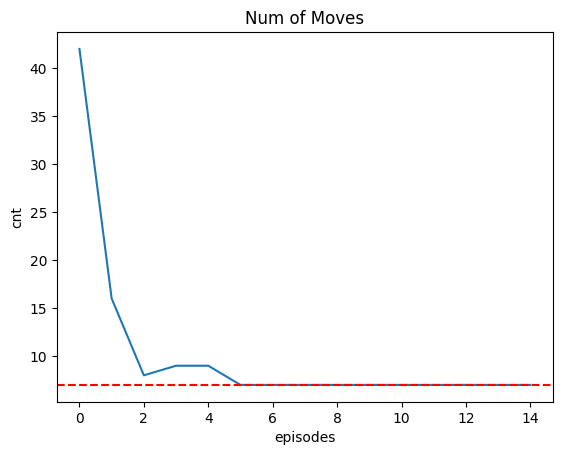

In [ ]:
plt.plot(total_moves)
plt.axhline(y=min(total_moves), color='r', linestyle='--')
plt.ylabel("cnt")
plt.xlabel("episodes")
plt.title("Num of Moves")
plt.show()

In [ ]:
policy_table_df = pd.DataFrame()

for x in range(env.height):
    for y in range(env.width):
        policy_table_df[f"({x},{y})"] = pi.policy_table[x][y]

policy_table_df = policy_table_df.T
col_names = dict(zip(range(len(env.action_space)), env.action_space))
policy_table_df.rename(columns=col_names, inplace=True)
policy_table_df

,up,down,left,right
"(0,0)",0.0,0.5,0.0,0.5
"(0,1)",0.0,0.5,0.0,0.5
"(0,2)",0.0,0.5,0.0,0.5
"(0,3)",0.0,0.5,0.0,0.5
"(0,4)",0.0,1.0,0.0,0.0
"(1,0)",0.0,0.5,0.0,0.5
"(1,1)",0.0,0.5,0.0,0.5
"(1,2)",0.0,0.5,0.0,0.5
"(1,3)",0.0,0.5,0.0,0.5
"(1,4)",0.0,1.0,0.0,0.0


# 가치 이터레이션

In [ ]:
class ValueIteration:
    def __init__(self, env):
        self.env = env
        self.action_space = env.action_space
        self.num_actions = env.num_actions
        self.value_table = np.zeros(shape=(env.height, env.width)).tolist()
        self.gamma = 0.9

    def value_iteration(self):
        for state in self.env.total_states:

            if state == self.env.end_point:
                self.value_table[state[0]][state[1]] = 0.0

            else:
                value_list = []
                for action_idx in range(self.num_actions):
                    next_state = self.env.state_after_action(state, action_idx)
                    reward = self.env.get_reward(state, action_idx)
                    next_value = self.get_value(next_state)
                    value = reward + self.gamma * next_value
                    value_list.append(value)

                self.value_table[state[0]][state[1]] = max(value_list)

    def get_action(self, state):
        if state == self.env.end_point:
            return []

        else:
            value_list = []
            for action_idx in range(self.num_actions):
                next_state = self.env.state_after_action(state, action_idx)
                reward = self.env.get_reward(state, action_idx)
                next_value = self.get_value(next_state)
                value = reward + self.gamma * next_value
                value_list.append(value)

            max_value = np.max(value_list)
            max_indices = np.where(value_list == max_value)[0]
            action_idx = np.random.choice(max_indices)
            # return max_indices
            return action_idx

    def get_value(self, state):
        return self.value_table[state[0]][state[1]]


In [ ]:
env = GridWorldEnvironment(start_point=(0,0),
                           end_point=(4,4),
                           gridworld_size=(5,5))

vi = ValueIteration(env)

EPISODES = 15
RENDER_END = True
total_moves = []

In [ ]:
for epi in range(EPISODES):
    move_cnt = 0
    env.traces = [] # traces 초기화
    state = env.start_point

    vi.value_iteration()

    while state != env.end_point:
        action_idx = vi.get_action(state)
        next_state = env.state_after_action(state, action_idx)
        state = next_state

        env.traces.append(state)
        move_cnt += 1

    total_moves.append(move_cnt)

    print(f"episode: {epi+1} / {EPISODES} __ move_cnt : {move_cnt}")

    if RENDER_END:
        env.render()

episode: 1 / 15 __ move_cnt : 9
S x x . . 
. . x . . 
. . x x . 
. . . x x 
. . . . A 
episode: 2 / 15 __ move_cnt : 30
S x x x . 
x x x x . 
x x x x . 
. . . x . 
. . . x A 
episode: 3 / 15 __ move_cnt : 13
S x . . . 
x x . . . 
. x x . . 
. . x . . 
. . x x A 
episode: 4 / 15 __ move_cnt : 10
S x x . . 
. . x . . 
. . x x x 
. . . . x 
. . . . A 
episode: 5 / 15 __ move_cnt : 8
S x . . . 
. x x . . 
. . x . . 
. . x x x 
. . . . A 
episode: 6 / 15 __ move_cnt : 9
S x . . . 
. x . . . 
. x . . . 
. x . . . 
. x x x A 
episode: 7 / 15 __ move_cnt : 8
S . . . . 
x x x x . 
. . . x x 
. . . . x 
. . . . A 
episode: 8 / 15 __ move_cnt : 8
S . . . . 
x . . . . 
x . . . . 
x x . . . 
. x x x A 
episode: 9 / 15 __ move_cnt : 8
S . . . . 
x . . . . 
x . . . . 
x x x . . 
. . x x A 
episode: 10 / 15 __ move_cnt : 8
S . . . . 
x . . . . 
x . . . . 
x x . . . 
. x x x A 
episode: 11 / 15 __ move_cnt : 8
S x . . . 
. x x x . 
. . . x . 
. . . x x 
. . . . A 
episode: 12 / 15 __ move_cnt : 8
S x .

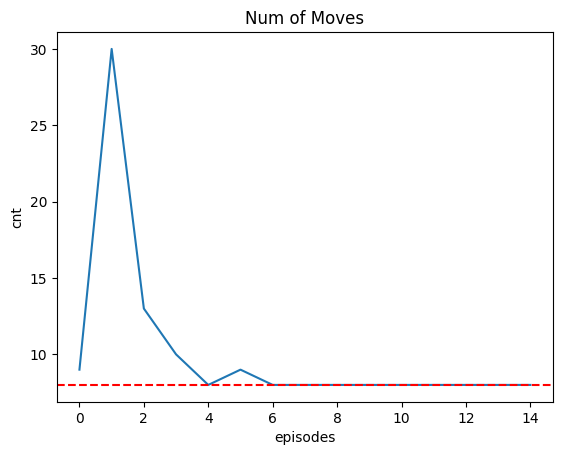

In [ ]:
plt.plot(total_moves)
plt.axhline(y=min(total_moves), color='r', linestyle='--')
plt.ylabel("cnt")
plt.xlabel("episodes")
plt.title("Num of Moves")
plt.show()

In [ ]:
np.array(vi.value_table).round(3)

array([[0.478, 0.531, 0.59 , 0.656, 0.729],
       [0.531, 0.59 , 0.656, 0.729, 0.81 ],
       [0.59 , 0.656, 0.729, 0.81 , 0.9  ],
       [0.656, 0.729, 0.81 , 0.9  , 1.   ],
       [0.729, 0.81 , 0.9  , 1.   , 0.   ]])